In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from math import *

In [2]:
try :
    with open('input.txt', 'r', encoding='utf-8') as f:
        text = f.read()
except:
    !wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
    with open('input.txt', 'r', encoding='utf-8') as f:
        text = f.read()
print(len(text))

# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

# Train and test splits
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.1*len(data)) # first 90% will be train, rest val
train_data = data[n:]
val_data = data[:n]

# data loading
def get_batch(split, block_size, batch_size):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

1115394


In [6]:
class Head(nn.Module):
    """one head of self-attention"""
    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)
        q = self.query(x)
        # compute attention score ("affinities")
        wei = q @ k.transpose(-2, -1) * C**-0.5
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1)# (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x)
        out = wei @ v # (B, T, C)
        return out




class MultiHeadAttention(nn.Module):
    """multiple heads of self-attention in parallel"""

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(num_heads * head_size, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out




class FeedForward(nn.Module):
    """a simple linear layer followed by a non-linearity"""

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)




class Block(nn.Module):
    """ Transformer block: communication followed by computation"""

    def __init__(self, n_embd, n_head):
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedForward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x


class Transformer(nn.Module):

    def __init__(self, vocab_size, n_embd, block_size, n_head, n_layer, device):
        super().__init__()
        self.vocab_size = vocab_size
        self.n_embd = n_embd
        self.block_size = block_size
        self.n_head = n_head
        self.n_layer = n_layer
        self.device = device

        # Token and positional embeddings
        self.token_embedding_table = nn.Embedding(self.vocab_size, self.n_embd)
        self.position_embedding_table = nn.Embedding(self.block_size, self.n_embd)
        
        # Transformer blocks
        self.blocks = nn.Sequential(*[Block(self.n_embd, n_head=self.n_head) for _ in range(self.n_layer)])
        
        # Layer normalization
        self.ln_f = nn.LayerNorm(self.n_embd)
        
        # Predict next token's embedding
        self.embedding_predictor = nn.Linear(self.n_embd, self.n_embd)

    def forward(self, idx, target=None):
        B, T = idx.shape

        # Token and position embeddings
        tok_emb = self.token_embedding_table(idx)  # (B, T, C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=self.device))  # (T, C)

        # Combine token and position embeddings
        x = tok_emb + pos_emb  # (B, T, C)

        # Pass through transformer blocks and layer normalization
        x = self.blocks(x)
        x = self.ln_f(x)
        
        # Predict the next token's embedding
        predicted_embeds = self.embedding_predictor(x)  # (B, T, C)
        
        loss = None
        if target is not None:
            target = self.token_embedding_table(target) + self.position_embedding_table(torch.arange(T, device=self.device))
            # Calculate the loss between predicted and actual embeddings
            loss = F.mse_loss(predicted_embeds, target)

        return predicted_embeds, loss
    
    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            idx = idx[:, -self.block_size:]
            # Get the prediction for the next token embedding
            predicted_embeds, _ = self.forward(idx)

            # Take the last embedding in the sequence and find the nearest token in embedding space
            last_embed = predicted_embeds[:, -1, :]  # (B, C)
            token_scores = torch.matmul(self.token_embedding_table.weight, last_embed.T).T  # (B, vocab_size)
            next_token = torch.argmax(token_scores, dim=-1, keepdim=True)  # (B, 1)

            # Append the predicted token to the sequence
            idx = torch.cat((idx, next_token), dim=1)  # (B, T+1)

        return idx
            
    
    def generate_old(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last self.block_size tokens
            idx_cond = idx[:, -self.block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx, idx_next



@torch.no_grad()
def estimate_loss(model, eval_iters, block_size, batch_size):
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split, block_size, batch_size)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

In [39]:
# hyperparameters
batch_size = 1 # how many independent sequences will we process in parallel?
block_size = 124 # what is the maximum context length for predictions? # impact little
eval_iters = 3 # more fast ( when it's low )
device = 'cuda' if torch.cuda.is_available() else 'cpu'
n_embd = 292  # impact big 8*12
n_head = 6    # no impact
n_layer = 6   # impact
dropout = 0.2 # no impact
# ------------

m = Transformer(vocab_size, n_embd, block_size, n_head, n_layer, device)

paras = list(str(sum(p.numel() for p in m.parameters())))
num = len(paras)-1
for i in paras:
  if num % 3 == 0:
    print(i, end=" ")
    pass
  else:
    print(i, end="")
    pass
  num -= 1

6 269 824 

  0%|          | 4/1500 [00:00<01:49, 13.71it/s]

step 0: train loss 0.0012, val loss 0.0010


  7%|▋         | 102/1500 [00:04<01:23, 16.68it/s]

step 100: train loss 0.0007, val loss 0.0009


 14%|█▎        | 204/1500 [00:09<01:10, 18.40it/s]

step 200: train loss 0.0009, val loss 0.0009


 20%|██        | 303/1500 [00:13<01:09, 17.28it/s]

step 300: train loss 0.0012, val loss 0.0014


 27%|██▋       | 402/1500 [00:18<01:03, 17.30it/s]

step 400: train loss 0.0010, val loss 0.0007


 34%|███▎      | 503/1500 [00:22<00:57, 17.43it/s]

step 500: train loss 0.0007, val loss 0.0010


 40%|████      | 602/1500 [00:26<00:51, 17.30it/s]

step 600: train loss 0.0010, val loss 0.0007


 47%|████▋     | 704/1500 [00:31<00:41, 19.00it/s]

step 700: train loss 0.0008, val loss 0.0015


 54%|█████▎    | 803/1500 [00:35<00:41, 16.79it/s]

step 800: train loss 0.0009, val loss 0.0006


 60%|██████    | 902/1500 [00:40<00:35, 16.97it/s]

step 900: train loss 0.0012, val loss 0.0009


 67%|██████▋   | 1004/1500 [00:44<00:26, 18.41it/s]

step 1000: train loss 0.0004, val loss 0.0013


 74%|███████▎  | 1103/1500 [00:49<00:23, 16.88it/s]

step 1100: train loss 0.0004, val loss 0.0009


 80%|████████  | 1202/1500 [00:53<00:17, 17.16it/s]

step 1200: train loss 0.0006, val loss 0.0010


 87%|████████▋ | 1304/1500 [00:58<00:10, 18.10it/s]

step 1300: train loss 0.0008, val loss 0.0008


 94%|█████████▎| 1403/1500 [01:02<00:05, 16.43it/s]

step 1400: train loss 0.0007, val loss 0.0008


100%|██████████| 1500/1500 [01:06<00:00, 22.43it/s]


tensor(0.0013, device='cuda:0', grad_fn=<MseLossBackward0>)


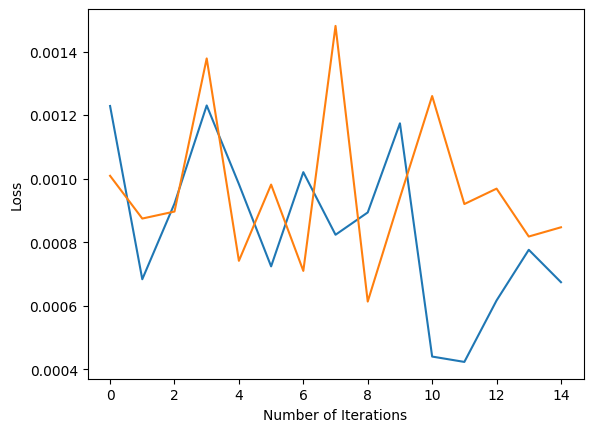

In [40]:
model = Transformer(vocab_size, n_embd, block_size, n_head, n_layer, device)
model.load_state_dict(torch.load('model'))
m = model.to(device)

# create a PyTorch optimizer
learning_rate = 1e-4
optimizer = torch.optim.AdamW(m.parameters(), lr=learning_rate)

loss_list_t = []
loss_list_v = []
max_iters = 1500
eval_interval = 100

for iter in tqdm(range(max_iters)):

    # every once in a while evaluate the loss on train and val sets

    if iter % eval_interval == 0:
        torch.save(m.state_dict(), 'model')

        losses = estimate_loss(m, eval_iters, block_size, batch_size)
        loss_list_t.append(losses['train'])
        loss_list_v.append(losses['val'])
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")


    # sample a batch of data
    xb, yb = get_batch('train', block_size, batch_size)

    # evaluate the loss
    logits, loss = model(xb, yb)
    #if iter % eval_interval == 0:
     # loss_list.append(loss.item())

    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

# draw loss
print(loss)
plt.plot(range(len(loss_list_t)), loss_list_t)
plt.plot(range(len(loss_list_v)), loss_list_v)
plt.xlabel("Number of Iterations")
plt.ylabel("Loss")
plt.show()

In [41]:
model = Transformer(vocab_size, n_embd, block_size, n_head, n_layer, device)
model.load_state_dict(torch.load('model'))
model.to(device)

context = torch.zeros((1, 1), dtype=torch.long, device=device)
#context = torch.tensor(encode("""
#First Citizen:
#Before we""")).unsqueeze(0).to(device)

for i in range(300):
    context = model.generate(context, 1)
    print(decode(context[:, -1].tolist()), end="")

x!Rz&!Gjz!3QqPqq&x$C$X?3$!U$$Px;.&x?ZQ-qqq3Jz;3zQ&zZjz&jx-jqjzJZqz&f&VJ--xYqYRzzzq-?z$?xVz3$-qq$xaQxxQQ?q&GJ-3-&x&&Qu!zz3-zuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuu